In [1]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import itertools

from ms_entropy.file_io.msp_file import read_one_spectrum
import sys
from rdkit import Chem, DataStructs
import functools

sys.path.append("../../src/ms_similarity_metrics/")
from create_spectrum import smile2inchi


In [2]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')   

In [3]:
QUERY_DIR = '../../data/mod_cosine_queries/'
QUERY_PATH = 's3://enveda-data-user/chloe.engler/cosine_similarity/modified_cosine_queries/nist_vs_nist/'
DATA_DIR = '../../data/'

UNWEIGHTED_FILE = 'nist_v_nist_10_ppm_2'
WEIGHTED_FILE = 'weighted_nist_v_nist_10_ppm_2'

# Get queries

In [4]:
# Get the NIST23 queries
queries = pd.read_csv(f'{QUERY_PATH}{UNWEIGHTED_FILE}.csv', index_col=0)
weighted_queries = pd.read_csv(f'{QUERY_PATH}{WEIGHTED_FILE}.csv', index_col=0)
# queries = pd.read_csv(f'{QUERY_DIR}{UNWEIGHTED_FILE}.csv', index_col=0)
# weighted_queries = pd.read_csv(f'{QUERY_DIR}{WEIGHTED_FILE}.csv', index_col=0)
print(queries.shape), print(weighted_queries.shape)

# Filter the queries to only include queries in both the weighted and unweighted queries
queries = queries[queries['wout_identifier'].isin(weighted_queries['wout_identifier'])]
weighted_queries = weighted_queries[weighted_queries['wout_identifier'].isin(queries['wout_identifier'])]

(402400, 6)
(354600, 6)


In [5]:
# Reformat the library_spectra_matches column to a list of tuples
all_matches = {}
for query in tqdm(queries.index.values):
    matches = []
    non_decimal = re.compile(r'[^\d.]+')

    test = queries.loc[query]['library_spectra_matches'].replace("'", "").replace(')', '').split('(')[1:]
    for pair in test:
        matches.append((pair.split(',')[0], float(non_decimal.sub('', pair.split(',')[1]))))

    all_matches[query] = matches
queries['library_spectra_matches'] = all_matches

#Reformat the library_spectra_matches column to a list of tuples for the weighted queries
all_weighted_matches = {}
for query in tqdm(weighted_queries.index.values):
    matches = []
    non_decimal = re.compile(r'[^\d.]+')

    test = weighted_queries.loc[query]['library_spectra_matches'].replace("'", "").replace(')', '').split('(')[1:]
    for pair in test:
        matches.append((pair.split(',')[0], float(non_decimal.sub('', pair.split(',')[1]))))
    all_weighted_matches[query] = matches
weighted_queries['library_spectra_matches'] = all_weighted_matches


100%|██████████| 354600/354600 [00:31<00:00, 11417.78it/s]


# Get NIST23 data

In [6]:
# Get NIST23 library
# Get data from s3://enveda-data-user/chloe.engler/cosine_similarity/NIST_data/NIST23-HR-MSMS.MSP
spectra_list = []
for i,spectrum in tqdm(enumerate(read_one_spectrum(f'{DATA_DIR}NIST23-HR-MSMS.MSP'))):
    spectra_list.append(spectrum)

1934658it [03:08, 10266.64it/s]


In [7]:
# Create NIST dataframe
nist_df = pd.DataFrame(spectra_list)
nist_df = nist_df[nist_df['precursor_type'] == '[M+H]+' ]

In [8]:
def create_identifier(x):
    if not pd.isna(x['cas#']):
        return str(x['index']) + '_' + x['cas#']
    else:
        return str(x['index']) + '_' + x['nist#']

In [9]:

nist_df = nist_df.reset_index(drop=False)
nist_df['indentifier'] = nist_df.apply(lambda x: create_identifier(x), axis=1)
nist_df.set_index('indentifier', inplace=True)

# Get smiles

In [10]:
# Get nist smiles dict
nist_smiles_dict = {}
for index in tqdm(nist_df.index.values):
    nist_smiles_dict[index] = nist_df.loc[index,'smiles']

100%|██████████| 567631/567631 [00:04<00:00, 134186.22it/s]


In [11]:
# Get wout smiles for unweighted queries
for i in tqdm(queries.index.values):
    wout_id = queries.loc[i, 'wout_identifier']
    queries.loc[i, 'wout_smiles'] = nist_smiles_dict[wout_id]

# Get wout smiles for weighted queries
for i in tqdm(queries.index.values):
    wout_id = queries.loc[i, 'wout_identifier']
    weighted_queries.loc[i, 'wout_smiles'] = nist_smiles_dict[wout_id]

100%|██████████| 354600/354600 [00:19<00:00, 18374.04it/s]


# Look at number of matches

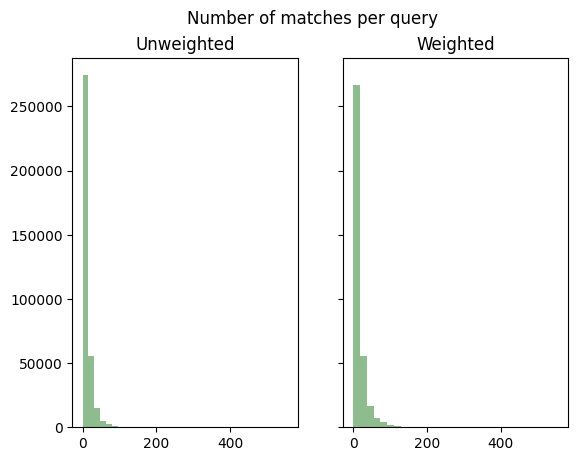

In [12]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

# Plot number of matches per query
num_matches = queries.library_spectra_matches.apply(lambda x: len(x))
ax1.hist(num_matches, bins=30, color='darkseagreen')
ax1.set_title('Unweighted')

# Plot number of matches per weighted query
num_matches = weighted_queries.library_spectra_matches.apply(lambda x: len(x))
ax2.hist(num_matches, bins=30, color='darkseagreen')
ax2.set_title('Weighted')

# Show plot
plt.suptitle('Number of matches per query')
plt.show()

# Get inchikeys

In [13]:
# Get NIST23 partial inchikeys
inchi_dict = {}
for i in tqdm(queries.index.values):
    inchi_list = []
    for pair in queries.loc[i, 'library_spectra_matches']:
        index = pair[0]
        inchi_list.append(nist_df.loc[index,'inchikey'][:14])
    inchi_dict[i] = inchi_list
queries['nist_inchis'] = queries.index.map(inchi_dict)

# Get NIST23 partial inchikeys for weighted queries
weighted_inchi_dict = {}
for i in tqdm(weighted_queries.index.values):
    inchi_list = []
    for pair in weighted_queries.loc[i, 'library_spectra_matches']:
        index = pair[0]
        inchi_list.append(nist_df.loc[index,'inchikey'][:14])
    weighted_inchi_dict[i] = inchi_list
weighted_queries['nist_inchis'] = queries.index.map(weighted_inchi_dict)

100%|██████████| 354600/354600 [00:45<00:00, 7841.38it/s] 


In [14]:
# Get wout partial inchikeys for queries
for i in tqdm(queries.index.values):
    inchi = smile2inchi(queries.loc[i, 'wout_smiles'])
    if inchi is None:
        queries.loc[i, 'wout_inchi'] = np.nan
    else:   
        queries.loc[i, 'wout_inchi'] = inchi[:14]

# Get wout partial inchikeys for weighted queries
for i in tqdm(weighted_queries.index.values):
    inchi = smile2inchi(weighted_queries.loc[i, 'wout_smiles'])
    if inchi is None:
        weighted_queries.loc[i, 'wout_inchi'] = np.nan
    else:   
        weighted_queries.loc[i, 'wout_inchi'] = inchi[:14]

  5%|▌         | 19400/354600 [00:13<03:56, 1415.88it/s][02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[02:23:43] Explicit valence for atom # 0 N, 4, is greater than permitted
  7%|▋         | 25407/354600 [00:17<03:20, 1642.07it/s][02:23:47] Explicit valence for atom # 11 O, 3, is greater than permitted
[02:23:47] Explicit valence for atom # 11 O, 3, is greater than permitted
[02:23:47]

# Look at exact matches

### Look at ranks of exact matches

In [15]:
# Get indexes of exact matches for queries
all_matches = {}
for i in tqdm(queries.index.values):
    exact_matches = np.where(np.array(list(queries.loc[i, 'nist_inchis'])) == queries.loc[i, 'wout_inchi'])[0]
    all_matches[i] = exact_matches
queries['exact_matches'] = queries.index.map(all_matches)

# Get indexes of exact matches for weighted queries
all_matches_weighted = {}
for i in tqdm(weighted_queries.index.values):
    exact_matches = np.where(np.array(list(weighted_queries.loc[i, 'nist_inchis'])) == weighted_queries.loc[i, 'wout_inchi'])[0]
    all_matches_weighted[i] = exact_matches
weighted_queries['exact_matches'] = queries.index.map(all_matches_weighted)




  0%|          | 0/354600 [00:00<?, ?it/s]/tmp/ipykernel_1209357/3679891818.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  exact_matches = np.where(np.array(list(queries.loc[i, 'nist_inchis'])) == queries.loc[i, 'wout_inchi'])[0]
  0%|          | 0/354600 [00:00<?, ?it/s]/tmp/ipykernel_1209357/3679891818.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  exact_matches = np.where(np.array(list(weighted_queries.loc[i, 'nist_inchis'])) == weighted_queries.loc[i, 'wout_inchi'])[0]
100%|██████████| 354600/354600 [00:07<00:00, 48959.77it/s]


In [16]:
# Get all ranks of exact matches
all_ranks = list(itertools.chain(*list(queries['exact_matches'])))
all_ranks_weighted = list(itertools.chain(*list(weighted_queries['exact_matches'])))

# Get highest rank of exact matches for each query
all_rank_1 = [x[0] for x in queries['exact_matches'] if len(x) > 0]
all_rank_1_weighted = [x[0] for x in weighted_queries['exact_matches'] if len(x) > 0]

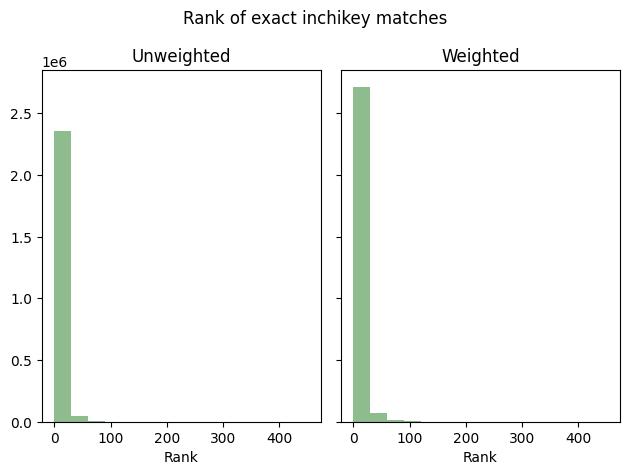

Median unweighted rank:  4.0
Median weighted rank:  4.0


In [17]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)

# Plot rank of exact matches
_,bins,_ = ax1.hist(all_ranks, bins=15, color='darkseagreen')
ax1.set_title('Unweighted')
ax1.set_xlabel('Rank')

# Plot rank of exact matches for weighted queries
ax2.hist(all_ranks_weighted, bins=bins, color='darkseagreen')
ax2.set_title('Weighted')
ax2.set_xlabel('Rank')

# Show plot
plt.suptitle('Rank of exact inchikey matches')
plt.tight_layout()
#plt.savefig('../figures/rank_modified_cosine.png', dpi=400)
plt.show()

print('Median unweighted rank: ', np.median(all_ranks))
print('Median weighted rank: ', np.median(all_ranks_weighted))

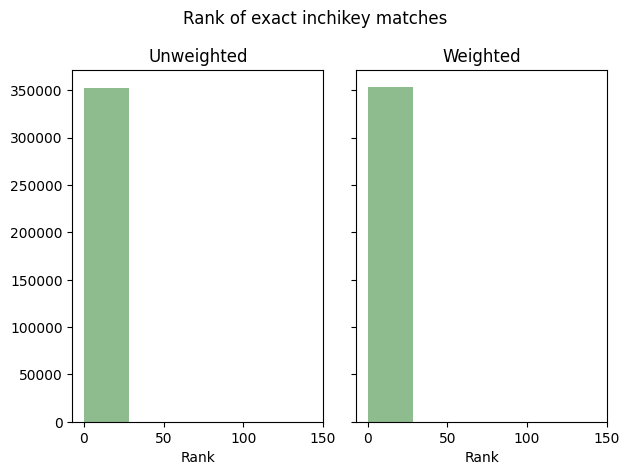

Median unweighted top rank:  0.0
Median weighted top rank:  0.0


In [18]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)

# Plot highest rank of exact matches
_,bins,_ = ax1.hist(all_rank_1, bins=5, color='darkseagreen')
ax1.set_title('Unweighted')
ax1.set_xlabel('Rank')

# Plot highest rank of exact matches for weighted queries
ax2.hist(all_rank_1_weighted, bins=bins, color='darkseagreen')
ax2.set_title('Weighted')
ax2.set_xlabel('Rank')

# Show plot
plt.suptitle('Rank of exact inchikey matches')
plt.tight_layout()
plt.show()

print('Median unweighted top rank: ', np.median(all_rank_1))
print('Median weighted top rank: ', np.median(all_rank_1_weighted))

#### Look at the percent of queries with an exact match in the top n matches

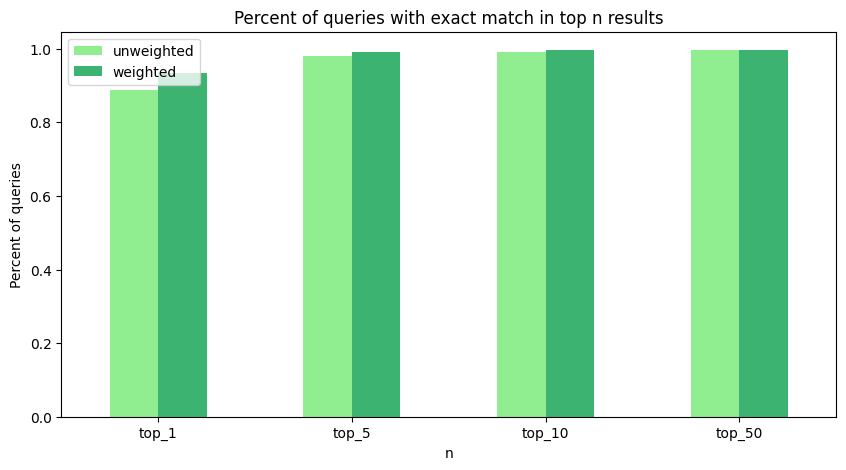

In [19]:
# Create data frame
exact_matches_top_n = pd.DataFrame(columns=['unweighted', 'weighted'], 
                                   index=['top_1', 'top_5', 'top_10', 'top_50'])
n_vals = [1, 5, 10, 50]

# Get percent of queries with exact match in top 5
for n in n_vals:
    exact_matches_top_n.loc[f'top_{n}', 'unweighted'] = queries.loc[queries['exact_matches'].apply(lambda x: min(x) \
                                                        if len(x) > 0 else np.nan)<n].shape[0] / queries.shape[0]
    exact_matches_top_n.loc[f'top_{n}', 'weighted'] =  weighted_queries.loc[weighted_queries['exact_matches'].apply(lambda x: min(x) \
                                                        if len(x) > 0 else np.nan)<n].shape[0] / weighted_queries.shape[0]

# Create bar plot
exact_matches_top_n.plot.bar(figsize=(10,5), rot=0, color=['lightgreen', 'mediumseagreen'])
plt.title('Percent of queries with exact match in top n results')
plt.ylabel('Percent of queries')
plt.xlabel('n')
plt.show()


# Non-exact match retrival

In [20]:
@functools.lru_cache
def _smiles_to_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None
@functools.lru_cache
def tanimoto(smiles1, smiles2):
    mol1, mol2 = _smiles_to_mol(smiles1), _smiles_to_mol(smiles2)
    if mol1 is None or mol2 is None:
        return np.nan
    fp1, fp2 = Chem.RDKFingerprint(mol1), Chem.RDKFingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [21]:
# Get NIST23 smiles for queries
all_smiles_dict = {}
for i in tqdm(queries.index.values):
    current_matches = queries.loc[i, 'library_spectra_matches']
    if len(current_matches) == 0:
        all_smiles_dict[i] = []
    else:
        nist_indexes = [x for x in np.array(queries.loc[i, 'library_spectra_matches'])[:,0]][:10]
        smiles_list = nist_df.loc[nist_indexes, 'smiles'].values
        all_smiles_dict[i] = smiles_list
queries[f'top_10_smiles'] = queries.index.map(all_smiles_dict)

# Get NIST23 smiles for weighted queries
all_weighted_smiles_dict = {}
for i in tqdm(weighted_queries.index.values):
    current_matches = weighted_queries.loc[i, 'library_spectra_matches']
    if len(current_matches) == 0:
        all_weighted_smiles_dict[i] = []
    else:
        nist_indexes = [x for x in np.array(weighted_queries.loc[i, 'library_spectra_matches'])[:,0]][:10]
        smiles_list = nist_df.loc[nist_indexes, 'smiles'].values
        all_weighted_smiles_dict[i] = smiles_list
weighted_queries[f'top_10_smiles'] = weighted_queries.index.map(all_weighted_smiles_dict)

100%|██████████| 354600/354600 [02:10<00:00, 2713.16it/s]


In [22]:
# Get dictionary of tanimoto scores
all_tanimotos = {}

# Get tanimoto scores for queries
for i in tqdm(queries.index.values):
    tanimotos = []
    query_smiles = queries.loc[i, 'wout_smiles']
    if len(queries.loc[i, f'top_10_smiles']) != 0:
        for library_smiles in queries.loc[i, f'top_10_smiles']:
            tanimotos.append(tanimoto(query_smiles, library_smiles))
        all_tanimotos[i] = [x for x in tanimotos if not pd.isna(x)]
    else:
        all_tanimotos[i] = []
queries[f'top_10_tanimoto'] = queries.index.map(all_tanimotos)

# Get dictionary of tanimoto scores
all_weighted_tanimotos = {}

# Get tanimoto scores for queries
for i in tqdm(weighted_queries.index.values):
    tanimotos = []
    query_smiles = weighted_queries.loc[i, 'wout_smiles']
    if len(weighted_queries.loc[i, f'top_10_smiles']) != 0:
        for library_smiles in weighted_queries.loc[i, f'top_10_smiles']:
            tanimotos.append(tanimoto(query_smiles, library_smiles))
        all_weighted_tanimotos[i] = [x for x in tanimotos if not pd.isna(x)]
    else:
        all_weighted_tanimotos[i] = []
weighted_queries[f'top_10_tanimoto'] = weighted_queries.index.map(all_weighted_tanimotos)


100%|██████████| 354600/354600 [02:28<00:00, 2383.29it/s]


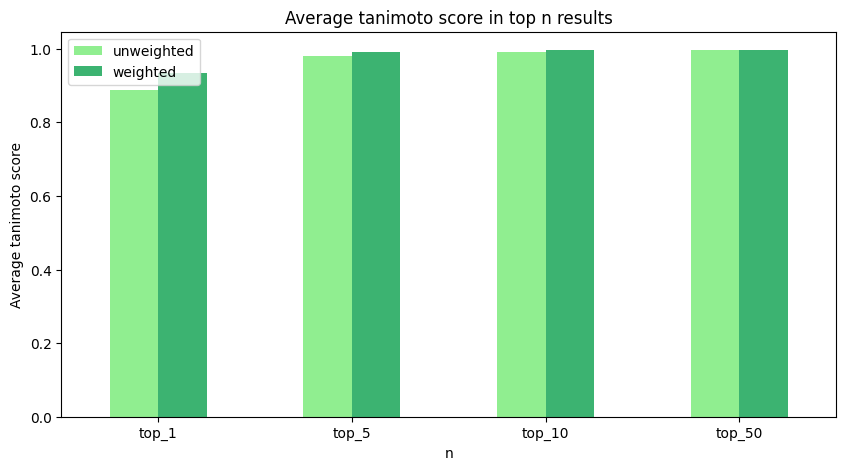

In [23]:
# Create data frame
average_tanimoto_top_n = pd.DataFrame(columns=['unweighted', 'weighted'], 
                                      index=['top_1', 'top_5', 'top_10'])
n_vals = [1, 5, 10]

# Calculate average tanimoto score for top n results
for i in n_vals:
    average_tanimoto_top_n.loc['unweighted', f'top_{n}'] = np.mean(list(itertools.chain.from_iterable([x[:n] for x in queries['top_10_tanimoto'] if len(x) > 0])))
    average_tanimoto_top_n.loc['weighted', f'top_{n}'] = np.mean(list(itertools.chain.from_iterable([x[:n] for x in weighted_queries['top_10_tanimoto'] if len(x) > 0])))

# Create bar plot
exact_matches_top_n.plot.bar(figsize=(10,5), rot=0, color=['lightgreen', 'mediumseagreen'])
plt.title('Average tanimoto score in top n results')
plt.ylabel('Average tanimoto score')
plt.xlabel('n')
plt.show()

# Look at AUC scores

In [24]:
from sklearn.metrics import roc_curve, auc

no_matches = 0

# Get AUC scores for queries
for index in tqdm(queries.index.values):
    if len(np.array(list(queries.loc[index,'library_spectra_matches']))) != 0:
        prob = np.array(list(queries.loc[index,'library_spectra_matches']))[:,1].astype('float')
        y_true = np.zeros(len(prob))
        y_true[queries.loc[index,f'exact_matches']] = 1

        # check if there arent any 1.0s in y_true
        if np.sum(y_true) == 0:
            queries.loc[index, f'auc'] = 0
        # check if all values are 1.0
        elif np.sum(y_true) == len(y_true):
            queries.loc[index, f'auc'] = 1
        else:
            fpr, tpr, thresholds = roc_curve(y_true, prob)
            queries.loc[index, f'auc'] = auc(fpr, tpr)
    else:
        no_matches += 1
        queries.loc[index, f'auc'] = np.nan

# Get AUC scores for weighted queries
for index in tqdm(weighted_queries.index.values):
    if len(np.array(list(weighted_queries.loc[index,'library_spectra_matches']))) != 0:
        prob = np.array(list(weighted_queries.loc[index,'library_spectra_matches']))[:,1].astype('float')
        y_true = np.zeros(len(prob))
        y_true[weighted_queries.loc[index,f'exact_matches']] = 1

        # check if there arent any 1.0s in y_true
        if np.sum(y_true) == 0:
            weighted_queries.loc[index, f'auc'] = 0
        # check if all values are 1.0
        elif np.sum(y_true) == len(y_true):
            weighted_queries.loc[index, f'auc'] = 1
        else:
            fpr, tpr, thresholds = roc_curve(y_true, prob)
            weighted_queries.loc[index, f'auc'] = auc(fpr, tpr)
    else:
        weighted_queries.loc[index, f'auc'] = np.nan

  1%|          | 3571/354600 [00:02<03:06, 1885.40it/s]

100%|██████████| 354600/354600 [03:06<00:00, 1902.79it/s]


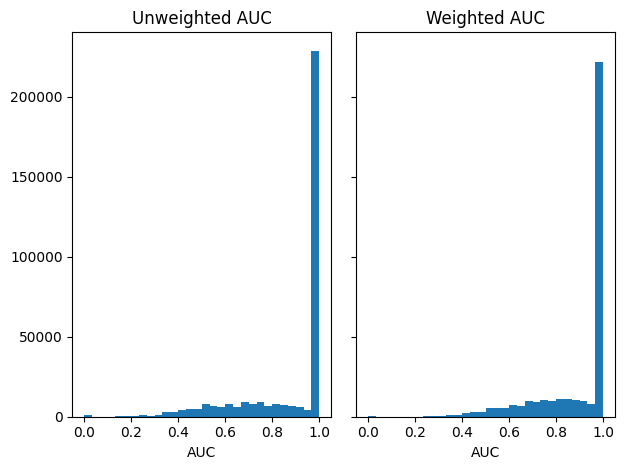

In [25]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Plot AUC scores for queries
ax1.hist(queries[f'auc'], bins=30)
ax1.set_title(f'Unweighted AUC')
ax1.set_xlabel('AUC')

# Plot AUC scores for weighted queries
ax2.hist(weighted_queries[f'auc'], bins=30)
ax2.set_title(f'Weighted AUC')
ax2.set_xlabel('AUC')

# Show plot
plt.tight_layout()
plt.show()